# A how-to for creating portfolios and simulating strategies with `backstroke`.

`backstroke` is a package for **writing custom investment `Strategy` classes** and **backtesting the simualted portfolios** based on them.

In practice, you define your desired assets and allocations in a `PortfolioMaker` instance, then pass the result to a `Strategy` to run the simulation. `backstroke` comes pre-equipped with a few `Strategy` classes; **in this walkthrough, we'll take a closer look at `SMAStrategy`**, which makes decisions on how to invest based on how a tracked asset's simple moving average (SMA) compares to its current price.

_While you do need some domain knowledge to run the package yourself, **no financial background is needed to follow this tutorial**, so read on to learn more about `backstroke` and I'll try to fill in the blanks where it's pertinent._

___
## Experimenting with `PortfolioMaker`. 💧

Before we use `SMAStrategy`, we have to build a `PortfolioMaker` instance with information about the assets we'll include in the portfolio.

In [1]:
from portfolio_maker import PortfolioMaker

**`PortfiolioMaker` instances follow a core/satellite model** where core assets' target portfolio fractions remain fixed over time but satellite assets' allocations are allowed to vary based on market conditions. To get things started, **we'll use a 60/40 split**.

In [11]:
pf = PortfolioMaker(sat_frac=.4, relative_core_frac=True)

We **divide the core portion** of the portfolio as follows:
- **50% in VUG** (large, US-based companies with explosive growth potential)
- **15% in VO** (mid-sized, US-based companies)
- **15% in EFG** (large, non-US companies with explosive growth potential)
- **15% in VBIIX** (intermediate term, highly graded bonds)
- **5% in ISHIX** (intermediate term, riskier bonds)

_(Again, don't worry if you're not familiar with these assets/terms.)_

In [12]:
pf.add_ticker('VUG', .5, label='core')
pf.add_ticker('VO', .15, label='core')
pf.add_ticker('EFG', .15, label='core')
pf.add_ticker('VBIIX', .15, label='core')
pf.add_ticker('ISHIX', .05, label='core')

_Note: You can edit a core asset's fraction after adding it to `PortfolioMaker` with the `edit_ticker_fraction()` method._

Satellite assets take an `'in_market'` argument instead of a fraction. It's typically `True` for riskier assets and `False` for safer ones.

Here, the **satellite portion** will contain:
- **SSO as the in-market asset** (riskier: leveraged 2x to the S&P 500's daily returns)
- **TLT as the out-market asset** (safer: long term US Treasury bonds)

In [14]:
pf.add_ticker('SSO', label='satellite', in_market=True)
pf.add_ticker('TLT', label='satellite', in_market=False)

_Note: You can edit a satellite asset's market status after adding it to `PortfolioMaker` with the `edit_ticker_mkt_status()` method. Remove tickers of any label with `remove_ticker()`._

`Strategy` classes can also take a **benchmark portfolio** to compare to the core/satellite. Besides their different labels, benchmark and core assets function similarly in `PortfolioMaker`. We'll choose a benchmark that matches standard beginner advice in investing.

**Important for `SMAStrategy`: one of the assets must have a 'track' attribute**, so we'll place it on SPY since it's often used as a gauge for how the market is doing as a whole.

In [15]:
pf.add_ticker('SPY', .6, label='benchmark', track=True) # tracks the S&P 500
pf.add_ticker('AGG', .4, label='benchmark') # the total US bond market

Finally, you can **check that `PortfolioMaker` objects are ready for use in a `Strategy`**. If no error is raised, we can move on to the next section.

In [16]:
pf.check_assets()

core assets and target holding fraction(s):
30.00000% in VUG
9.00000% in VO
9.00000% in EFG
9.00000% in VBIIX
3.00000% in ISHIX
*** 60.00000% in core overall ***
----------------
satellite assets and target holding fraction(s):
in-market asset:     SSO
out-of-market asset: TLT
*** 40.00000% in satellite overall ***
----------------
-----passed-----
----------------
benchmark assets and target holding fraction(s):
60.00000% in SPY
40.00000% in AGG
*** 100.00000% in benchmark overall ***
----------------
-----passed-----



## Simulating a `Strategy`. 💧

**Once the portfolio is ready to go, we can create an instance of `SMAStrategy`.**

As a reminder, this `Strategy` places all of its portfolio's satellite portion into either the in-market or out-market asset depending on how a tracked asset's current price (in our case, SPY) compares to its simple moving average.

_For more information on arguments and why this is a sensible approach, read the docstrings for `SMAStrategy` and `HistoricalSimulator` after importing them below by clicking either name in a code cell and pressing `Shift`+`Tab`._

In [19]:
from simulator import HistoricalSimulator
from strategies import SMAStrategy
import pandas as pd

**We include `pf` as the first argument**. With the others, we specify:
- ...that the `Strategy` will make decisions based on its tracked asset's **200 day SMA**;
- ...that we'll start the portfolio off with **$10,000 in cash**;
- ...that the simulation will cover **June 1, 2007 through June 1, 2015**.
- ...that **the satellite portion will be rebalanced six times a year**, or every other month;
- ...that **the total portfolio will be rebalanced three times a year**, or every four months;
- ...that rebalances should happen on the **second-to-last market day** of eligible months.
- ...and that **any dividends are reinvested** back into the assets from which they came.

In [20]:
sim = SMAStrategy(pf, burn_in=200, cash=1e4,
                  start_date=pd.Timestamp(2007, 6, 1),
                  end_date=pd.Timestamp(2015, 6, 1),
                  sat_rb_freq=6, tot_rb_freq=3, target_rb_day=-2
                  reinvest_dividends=True)

core assets and target holding fraction(s):
30.00000% in VUG
9.00000% in VO
9.00000% in EFG
9.00000% in VBIIX
3.00000% in ISHIX
*** 60.00000% in core overall ***
----------------
satellite assets and target holding fraction(s):
in-market asset:     SSO
out-of-market asset: TLT
*** 40.00000% in satellite overall ***
----------------
-----passed-----
----------------
benchmark assets and target holding fraction(s):
60.00000% in SPY
40.00000% in AGG
*** 100.00000% in benchmark overall ***
----------------
-----passed-----

VUG from 2006-08-11 to 2015-06-01...
VO from 2006-08-11 to 2015-06-01...
EFG from 2006-08-11 to 2015-06-01...
VBIIX from 2006-08-11 to 2015-06-01...
ISHIX from 2006-08-11 to 2015-06-01...
SSO from 2006-08-11 to 2015-06-01...
TLT from 2006-08-11 to 2015-06-01...
SPY from 2006-08-11 to 2015-06-01...
AGG from 2006-08-11 to 2015-06-01...
sat [ 8 12  4] 
tot [10  2  6]
[ 6  7  8  9 10 11 12] 2007
[ 1  2  3  4  5  6  7  8  9 10 11 12] 2008
[ 1  2  3  4  5  6  7  8  9 10 11 12

**The main attribute to note is `assets`**, a nested dictionary organized by asset name. Individual asset dictionaries contain the number of shares currently held, downloaded price data, and the attributes we specified in `PortfolioMaker`.

In [23]:
list(sim.assets.keys())

['VUG', 'VO', 'EFG', 'VBIIX', 'ISHIX', 'SSO', 'TLT', 'SPY', 'AGG']

In [24]:
sim.assets['VUG']['df'].head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2006-08-11,51.33,51.56,51.16,51.56,90900,43.208294,43.401903,43.065193,43.401903,90900,0.0,1.0
2006-08-14,51.40,51.91,51.40,51.75,53900,43.267219,43.696524,43.267219,43.561840,53900,0.0,1.0
2006-08-15,52.28,52.28,51.80,52.10,81300,44.007980,44.007980,43.603928,43.856461,81300,0.0,1.0
2006-08-16,52.97,53.00,52.46,52.56,43900,44.588805,44.614058,44.159500,44.243677,43900,0.0,1.0
2006-08-17,53.10,53.29,52.89,53.00,72500,44.698236,44.858173,44.521463,44.614058,72500,0.0,1.0


We can now **run the simulation in one line**.

_Note: i) to see a log of transactions, add `verbose=True` as an argument. ii) Keep in mind that each class instance is only good for one simulation._

In [26]:
sim.begin_time_loop()

From here, we can **plot and compare our portfolio's results against the benchmark**.

end date main portfolio value: $24,744.55
end date main portfolio shares: 
VUG: 71.8, VO: 18.3, EFG: 33.6, VBIIX: 223.6, ISHIX: 96.7, SSO: 149.6, TLT: 0.0

end date benchmark portfolio value: $20,730.05
end date benchmark portfolio shares: 
SPY: 65.4, AGG: 84.8


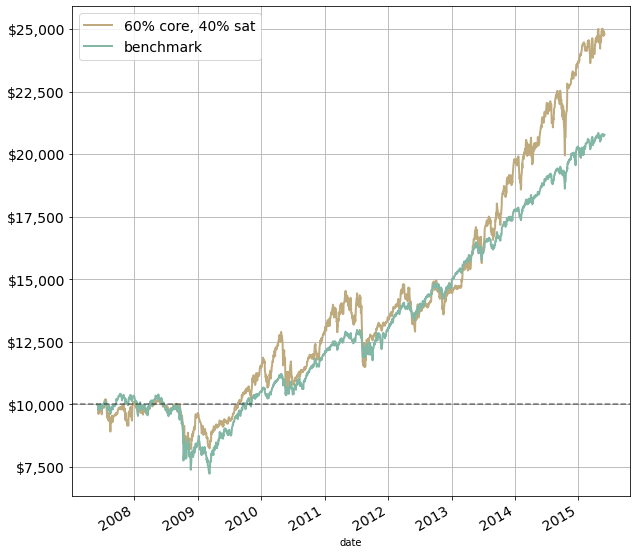

In [28]:
sim.plot_results()

___
## The idea from here...
...is to try out different `Strategy` instances and vary assets, core/satellite allocations, dates, rebalance frequencies, and so on to **perhaps translate what you've learned to your real-life investments**. As long as they inherit from `HistoricalSimulator`, you may also **create `Strategy` classes that follow your own logic** and see how they perform.

If you're interested in seeing how another, simpler strategy works, take a look at [`buy_and_hold.ipynb`](buy_and_hold.ipynb).